In [691]:
import pandapower as pp
import pandapower.networks as nw
import pandapower.plotting as plot
import matplotlib.pyplot as plt
import math
import numpy as np
import copy
import pandapower.shortcircuit as sc
#from matplotlib.transforms import BlendedGenericTransform
#from pandapower.plotting import simple_plot, simple_plotly, pf_res_plotly

# Predefined network of IEEE 4gs bus system 
net = pp.networks.case4gs()
#plot.simple_plot(net)

In [692]:
####Shunt FACTS device (bus 1)
#MV bus
bus_SVC = pp.create_bus(net, name='MV SVCtrafo bus', vn_kv=69, type='n', geodata=(-2,2.5), zone=2, max_vm_pu=1.1,
                        min_vm_pu=0.9)
#Trafo
trafoSVC = pp.create_transformer_from_parameters(net, hv_bus=1, lv_bus=4, in_service=True, 
                                                name='trafoSVC', sn_mva=110, vn_hv_kv=230 , vn_lv_kv=69, 
                                                vk_percent=12, vkr_percent=0.26, pfe_kw=55, i0_percent=0.06,
                                                shift_degree=0, tap_side='hv', tap_neutral=0, tap_min=-9, tap_max=9,
                                                tap_step_percent=1.5, tap_step_degree=0, tap_phase_shifter=False) 
#Breaker between grid HV bus and trafo HV bus to connect buses
sw_SVC = pp.create_switch(net, bus=1, element=0, et='t', type='CB', closed=False)
#Shunt devices connected with MV bus
shuntDev = pp.create_shunt(net, bus_SVC, 1, in_service=True, name='Shunt Device', step = 1)

In [693]:
####Series device (at line 3, in middle between bus 2 and 3)
#Add intermediate buses for bypass and series compensation impedance
bus_SC1 = pp.create_bus(net, name='SC bus 1', vn_kv=230, type='n', geodata=(-1,3.1), zone=2, max_vm_pu=1.1, min_vm_pu=0.9)
bus_SC2 = pp.create_bus(net, name='SC bus 2', vn_kv=230, type='n', geodata=(-1,3.0), zone=2, max_vm_pu=1.1, min_vm_pu=0.9)
sw_SC_bypass = pp.create_switch(net, bus=5, element=6, et='b', type='CB', closed=True)
imp_SC = pp.create_impedance(net, from_bus=5, to_bus=6, rft_pu=0.0000001272, xft_pu=-0.0636,
                             rtf_pu=0.0000001272, xtf_pu=-0.0636, sn_mva=250, in_service=True) #Just some default values
#Adjust orginal Line 3 to connect to new buses instead.
net.line.at[3, ['length_km', 'to_bus', 'name']] = [0.5, 5, 'line1_SC']                        
lineSC2 = pp.create_line_from_parameters(net, name='line2_SC', c_nf_per_km=net.line.at[3,'c_nf_per_km'],
                       df=net.line.at[3, 'df'], from_bus=6, g_us_per_km=net.line.at[3, 'g_us_per_km'],
                       in_service=net.line.at[3, 'in_service'], length_km=0.5, max_i_ka=net.line.at[3, 'max_i_ka'],
                       max_loading_percent=net.line.at[3, 'max_loading_percent'], parallel=net.line.at[3, 'parallel'],
                       r_ohm_per_km=net.line.at[3, 'r_ohm_per_km'], std_type=net.line.at[3, 'std_type'], to_bus=3, 
                       type=net.line.at[3, 'type'], x_ohm_per_km=net.line.at[3, 'x_ohm_per_km'])

In [694]:
###EXCHANGE PV GEN INTO SGEN
pp.runpp(net)
net.gen.drop(index=[0], inplace= True) #Drop PV generator
sgen_nom_p_mw = net.res_gen.p_mw # Set generator nominal output as output of generator during IEEE nominal setup
sgen_nom_q_mvar = net.res_gen.q_mvar
sgen_nom_s_mva = math.sqrt(sgen_nom_p_mw**2 + sgen_nom_q_mvar**2)
sgen = pp.create_sgen(net, 3, p_mw=sgen_nom_p_mw, q_mvar=sgen_nom_q_mvar, name='static generator', scaling=1, 
                      sn_mva=sgen_nom_s_mva)
sgen_nom_s_mva

366.14270273188276

In [695]:
##Function for transition from reference power to reactance of "TCSC"
def K_x_comp_pu(net, x_line_pu, p_ref_pu):
    k_x_comp_max_ind = 0.2 #maximum inductive reactance compensation of the line
    k_x_comp_max_cap = -0.8 #maximum capacitive reactance compensation of the line
    v_s_pu = net.res_bus.vm_pu[3]
    v_r_pu = net.res_bus.vm_pu[2]
    delta_deg = net.res_bus.va_degree[3] - net.res_bus.va_degree[2]
    k_x_comp = ((v_s_pu * v_r_pu * math.sin(math.radians(delta_deg))) / (p_ref_pu* x_line_pu)) - 1
    #print(k_x_comp)
    
    if k_x_comp > k_x_comp_max_ind:
        k_x_comp = k_x_comp_max_ind
    if k_x_comp < k_x_comp_max_cap:
        k_x_comp = k_x_comp_max_cap
    return k_x_comp

p_ref_pu = 1
S_base = 100e6
V_base = 230e3
x_base = pow(V_base,2) / S_base
x_line_ohm = net.line.x_ohm_per_km[3]
x_line_pu = x_line_ohm / x_base # Can take one since this line is divivded into 
                                              # 2 identical lines with length 0.5 km  
k_x_comp_pu = K_x_comp_pu(net, x_line_pu, p_ref_pu)
print(k_x_comp_pu)

-0.08019101536084383


In [696]:
## Function for transition from reference parameter to reactive power output of shunt device
def Shunt_q_comp(net, v_ref_pu):
    v_bus_pu = net.res_bus.vm_pu[1]
    k = 25 #Coefficient for transition, tuned to hit 1 pu with nominal IEEE
    q_rated = 100 #Mvar
    q_min = -q_rated
    q_max = q_rated
    q_comp = k*q_rated*(v_bus_pu-v_ref_pu)    
    
    if q_comp > q_max:
        q_comp = q_max
    if q_comp < q_min:
        q_comp = q_min
    
    return q_comp

q_comp = Shunt_q_comp(net, 1)
q_comp

-43.94691498926184

In [697]:
##Function for nose curve
def NoseCurve(p_low_pu, p_high_pu, bus_index, net, x_line_pu, shunt, sc):
    network = copy.deepcopy(net) #To not changing anything in actual network
    fig = plt.figure()
    
    l_arr = np.linspace(p_low_pu, p_high_pu, 100)
    l_len = len(l_arr)
    v_res = np.zeros(l_len)
    l_ind = bus_index
    l_p_mw = network.load.p_mw[l_ind]
    l_q_mvar = network.load.q_mvar[l_ind]
    
    #Disable FACTS initially to get proper transition
    network.switch.closed[0] = False 
    network.switch.closed[1] = True
    
    for ind in range(l_len):
        
        #
        l_scaling = l_arr[ind]
        network.load.p_mw[l_ind] = l_p_mw*l_scaling
        network.load.q_mvar[l_ind] = l_q_mvar*l_scaling
        pp.runpp(network)
        
        # Shunt compensation
        v_ref_pu = 1
        q_comp = Shunt_q_comp(network, v_ref_pu)
        network.shunt.q_mvar =  q_comp
        #print(network.shunt.q_mvar)
        
        # Series compensation
        p_ref_pu = 2
        k_x_comp_pu = K_x_comp_pu(network, x_line_pu, p_ref_pu)
        network.impedance.loc[0, ['xft_pu','xtf_pu']] = x_line_pu * k_x_comp_pu
        #print(k_x_comp_pu)
        
        # Enable FACTS devices if they should be
        network.switch.closed[0] = shunt 
        aa = network.switch.closed[1] != sc
              
        pp.runpp(network)
        v_res[ind] = network.res_bus.vm_pu[l_ind]
        
        # Reset FACTS devices to get proper transition next time step.
        network.switch.closed[0] = False 
        network.switch.closed[1] = True

    plt.plot(l_arr, v_res, figure=fig)
    plt.ylabel('Bus Voltage [pu]')
    plt.xlabel('Active power [pu]')
    plt.grid(True)
    
    return [fig, v_res, l_arr]

In [698]:
##Function to merge figures into 1
def MergeFig(v_res1, l_arr1, label1, v_res2, l_arr2, label2, v_res3, l_arr3, label3):
    fig = plt.figure()
    plt.plot(l_arr1, v_res1, figure=fig, label=label1)
    plt.plot(l_arr2, v_res2, figure=fig, label=label2)
    plt.plot(l_arr3, v_res3, figure=fig, label=label3)
    plt.ylabel('Bus Voltage [pu]')
    plt.xlabel('Active power load at bus [scaling relative to nominal IEEE]')
    plt.grid(True)
    plt.legend()
    return fig    

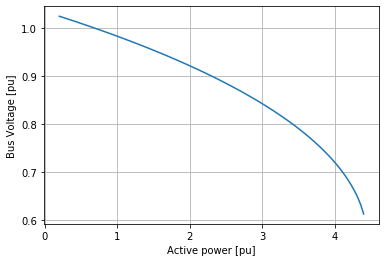

In [699]:
NoseCurve1 = NoseCurve(0.2,4.4,1, net, x_line_pu, shunt=False, sc= False)

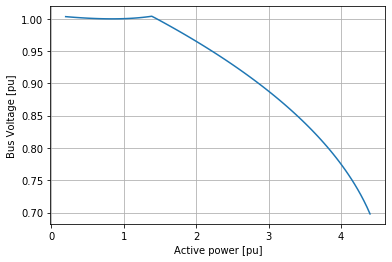

In [700]:
NoseCurve2 = NoseCurve(0.2,4.4,1, net, x_line_pu, shunt=True, sc=False)

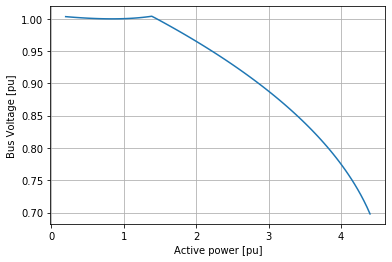

In [701]:
NoseCurve3 = NoseCurve(0.2,4.4,1, net, x_line_pu, shunt=True, sc=True)

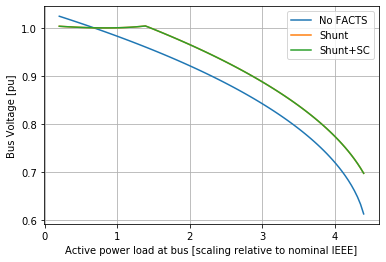

In [702]:
figMerge1 = MergeFig(NoseCurve1[1], NoseCurve1[2], 'No FACTS', 
                     NoseCurve2[1], NoseCurve2[2], 'Shunt',
                     NoseCurve3[1], NoseCurve3[2], 'Shunt+SC')

In [703]:
# RESULTS WITHOUT FACTS:
pp.runpp(net)
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.000000,0.000000,-136.806814,-83.441420
1,0.982421,-0.977077,170.000000,105.350000
2,0.969031,-1.871668,200.000000,123.940000
3,1.020000,1.521408,-238.000000,-131.904101
4,NaN,NaN,0.000000,0.000000
5,0.995088,-0.143270,0.000000,0.000000
6,0.995088,-0.143270,0.000000,0.000000


In [704]:
net.res_line.loading_percent

0    20.182829
1    47.877698
2    61.462187
3    49.274683
4    48.021956
Name: loading_percent, dtype: float64

In [705]:
# ENABLING OF FACTS
# Enabling shunt device, true means enabled
net.switch.closed[0] = True
net.trafo.tap_pos[0] = 0


In [706]:
#Shunt
v_ref_pu = 1
q_comp = Shunt_q_comp(net, v_ref_pu)
net.shunt.q_mvar =  q_comp

#Series
p_ref_pu = 2
k_x_comp_pu = K_x_comp_pu(net, x_line_pu, p_ref_pu)
net.impedance.loc[0, ['xft_pu','xtf_pu']] = x_line_pu * k_x_comp_pu
print(k_x_comp_pu)

pp.runpp(net)

-0.5400955076804212


In [707]:
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.000000,0.000000,-136.736152,-35.754866
1,1.000002,-1.157231,170.000000,105.350000
2,0.973874,-1.920040,200.000000,123.940000
3,1.032460,1.320612,-238.000000,-131.904101
4,1.050323,-1.221479,0.000000,-48.481299
5,1.003784,-0.264013,0.000000,0.000000
6,1.003784,-0.264013,0.000000,0.000000


In [708]:
net.res_line.loading_percent

0    16.225624
1    45.119073
2    58.244243
3    51.730341
4    50.284613
Name: loading_percent, dtype: float64

In [709]:
# Enabling the series compensation, False means enabled
net.switch.at[1, 'closed'] = False
pp.runpp(net)
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.000000,0.000000,-136.784153,-33.784250
1,0.997538,-1.402270,170.000000,105.350000
2,0.976396,-1.742064,200.000000,123.940000
3,1.028304,0.916663,-238.000000,-131.904101
4,1.047735,-1.466517,0.000000,-48.242709
5,1.008307,0.049071,0.000000,0.000000
6,0.997947,-0.833428,0.000000,0.000000


In [715]:
net.line

,c_nf_per_km,df,from_bus,g_us_per_km,in_service,length_km,max_i_ka,max_loading_percent,name,parallel,r_ohm_per_km,std_type,to_bus,type,x_ohm_per_km
0,513.969177,1.0,0,0.0,True,1.0,0.627555,100.0,None,1,5.33232,None,1,ol,26.6616
1,388.610841,1.0,0,0.0,True,1.0,0.627555,100.0,None,1,3.93576,None,2,ol,19.6788
2,388.610841,1.0,1,0.0,True,1.0,0.627555,100.0,None,1,3.93576,None,3,ol,19.6788
3,639.327512,1.0,2,0.0,True,0.5,0.627555,100.0,line1_SC,1,6.72888,None,5,ol,33.6444
4,639.327512,1.0,6,0.0,True,0.5,0.627555,100.0,line2_SC,1,6.72888,None,3,ol,33.6444


,in_service,max_vm_pu,min_vm_pu,name,type,vn_kv,zone
0,True,1.1,0.9,0,b,230.0,1
1,True,1.1,0.9,1,b,230.0,1
2,True,1.1,0.9,2,b,230.0,1
3,True,1.1,0.9,3,b,230.0,1
4,True,1.1,0.9,MV SVCtrafo bus,n,69.0,2
5,True,1.1,0.9,SC bus 1,n,230.0,2
6,True,1.1,0.9,SC bus 2,n,230.0,2


In [716]:
net.ext_grid

,bus,in_service,name,va_degree,vm_pu,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar
0,0,True,None,0.0,1.0,0.0,0.0,100.0,-100.0


In [717]:
net.bus

,in_service,max_vm_pu,min_vm_pu,name,type,vn_kv,zone
0,True,1.1,0.9,0,b,230.0,1
1,True,1.1,0.9,1,b,230.0,1
2,True,1.1,0.9,2,b,230.0,1
3,True,1.1,0.9,3,b,230.0,1
4,True,1.1,0.9,MV SVCtrafo bus,n,69.0,2
5,True,1.1,0.9,SC bus 1,n,230.0,2
6,True,1.1,0.9,SC bus 2,n,230.0,2


AttributeError: 'DataFrame' object has no attribute 'geodata'